In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

sys.path.append(os.path.abspath(os.path.join('..', 'src')))

from data_loader import load_bearing_data, compute_melspec, creadte_dataset_windows

c:\Users\kweru\Desktop\EchoGuard\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
DATA_DIR = '../data/raw/2nd_test'
files = sorted(os.listdir(DATA_DIR))

healthy_files = files[0:100]
failure_files = files[-5]

print(f'Loading {len(healthy_files)} data...')

all_windows = []
for filename in healthy_files:
	df = load_bearing_data(filename, DATA_DIR)
	melspec = compute_melspec(df)
	norm_mel = (melspec - (-80)) / (0 - (-80))
	windows = creadte_dataset_windows(norm_mel)
	all_windows.append(windows)

X_train = np.concatenate(all_windows, axis=0)
print(f'Traing data shape: {X_train.shape}')

df_failure = load_bearing_data(failure_files, DATA_DIR)
mel_fail = compute_melspec(df_failure)
norm_fail = (mel_fail - (-80)) / (0 - (-80))
X_test_anomaly = creadte_dataset_windows(norm_fail)

print(f'Anomaly shape: {X_test_anomaly.shape}')

Loading 100 data...
Traing data shape: (400, 128, 64, 1)
Anomaly shape: (4, 128, 64, 1)


In [3]:
def build_autoencoder(input_shape):
	model = models.Sequential()
	model.add(layers.Input(shape=input_shape))
	
	model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same'))
	model.add(layers.MaxPooling2D((2,2), padding='same'))
	model.add(layers.Conv2D(16, (3,3), activation='relu', padding='same'))
	model.add(layers.MaxPooling2D((2,2), padding='same'))

	model.add(layers.Conv2D(16, (3,3), activation='relu', padding='same'))
	model.add(layers.UpSampling2D((2,2)))
	model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same'))
	model.add(layers.UpSampling2D((2,2)))

	model.add(layers.Conv2D(1, (3,3), activation='sigmoid', padding='same'))

	return model

input_shape = (128, 64, 1)
model = build_autoencoder(input_shape)

model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 64, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 32, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 16, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 64, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 128, 64, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 64, 1)     │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,193 (47.63 KB)

 Trainable params: 12,193 (47.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 5.1093e-04 - val_loss: 5.2265e-04
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 5.3111e-04 - val_loss: 5.3102e-04
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 5.1537e-04 - val_loss: 5.1647e-04
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 5.0309e-04 - val_loss: 5.2165e-04
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 5.0543e-04 - val_loss: 5.2247e-04
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 5.2086e-04 - val_loss: 5.3074e-04
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 5.1365e-04 - val_loss: 5.1530e-04
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 5.1607e-04 - val_loss: 5.1906e-04
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 4.9958e-04 - val_loss: 5.1011e-04
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 5.0235e-04 - val_loss: 5.0206e-04
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 4.9932e-0

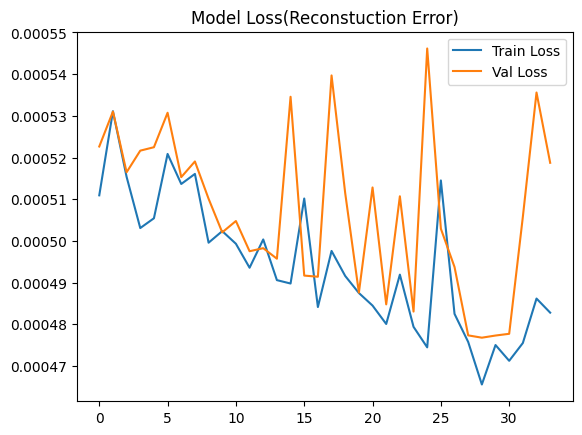

In [8]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min',
    restore_best_weights=True
)

history = model.fit(
    X_train, X_train, 
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping],
    shuffle=True 
)

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Model Loss(Reconstuction Error)')
plt.show()